In [1]:
import numpy as np
import os
import PIL
import matplotlib.pyplot as plt
import sys
import torch
sys.path.append("./Utils")
from utils import get_loaders, load_checkpoint
sys.path.append('./Models')
from U_net import UNET
import torchvision

In [2]:
path_train = "../Data/dataset_DRIVE/training/images/"
training_images = os.listdir(path_train)

In [3]:
train_images = {}
for i in sorted(training_images):
    number = i[0:2]
    img = np.array(PIL.Image.open(f'{path_train}{i}').convert("RGB"))
    train_images[str(number)] =  img

In [4]:
train_images['21'].shape

(584, 565, 3)

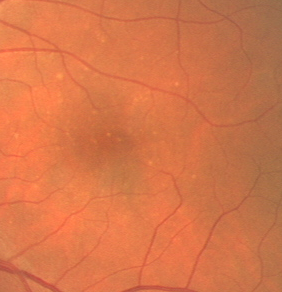

In [5]:
from torchvision.transforms import RandomCrop
from torchvision.transforms import Compose, ToTensor, RandomAffine
import torchvision.transforms.functional as TF
i, j, h, w = RandomCrop.get_params(
            PIL.Image.fromarray(np.uint8(train_images['21'])).convert('RGB'),
             output_size=(292, 282))
TF.crop(PIL.Image.fromarray(np.uint8(train_images['21'])).convert('RGB'), i, j, h, w)

Text(0.5, 1.0, '21')

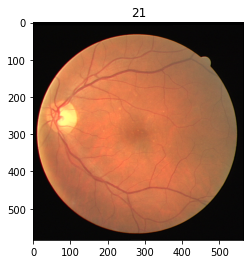

In [6]:
plt.imshow(train_images['21'])
plt.title('21')

(584, 565, 3)


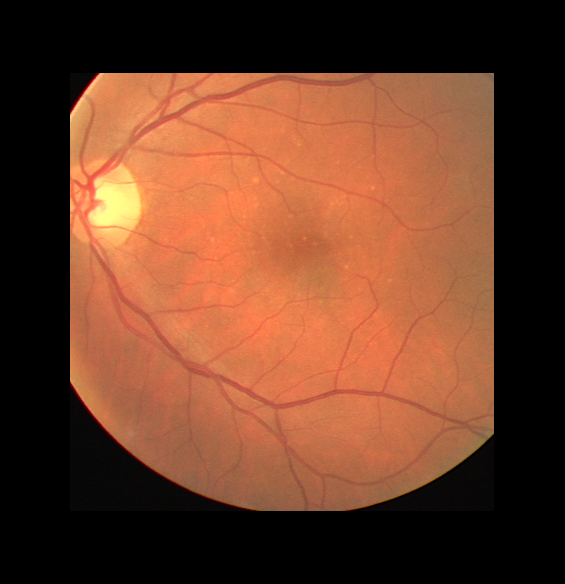

In [7]:
size = (438, 424)
i, j, h, w = RandomCrop.get_params(
            PIL.Image.fromarray(np.uint8(train_images['21'])).convert('RGB'),
             output_size=size)
TF.crop(PIL.Image.fromarray(np.uint8(train_images['21'])).convert('RGB'), i, j, h, w)
up_down_pad = 584 - size[0]
left_right_pad = 565 - size[1]
top = up_down_pad//2
bottom = top + up_down_pad % 2
left = left_right_pad//2
right = left + left_right_pad % 2
cropped = TF.crop(PIL.Image.fromarray(np.uint8(train_images['21'])).convert('RGB'), i, j, h, w)
print(np.asarray(TF.pad(cropped, (left, top, right, bottom))).shape)
TF.pad(cropped, (left, top, right, bottom))

In [8]:
class AddGaussianNoise(object):
    def __init__(self, mean=0., std=1.):
        self.std = std
        self.mean = mean
        
    def __call__(self, tensor):
        return torch.clip(tensor + torch.randn(tensor.size()) * self.std + self.mean, 0, 1)
    
    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)

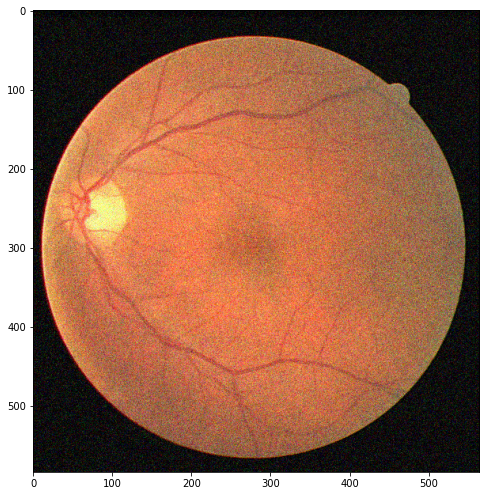

In [9]:
transform=Compose([
    ToTensor(),
    AddGaussianNoise(0, 0.1)
])

examp = transform(train_images['21'])
plt.figure(figsize=[8,9])
plt.imshow(examp.permute(1, 2, 0) , alpha=1)

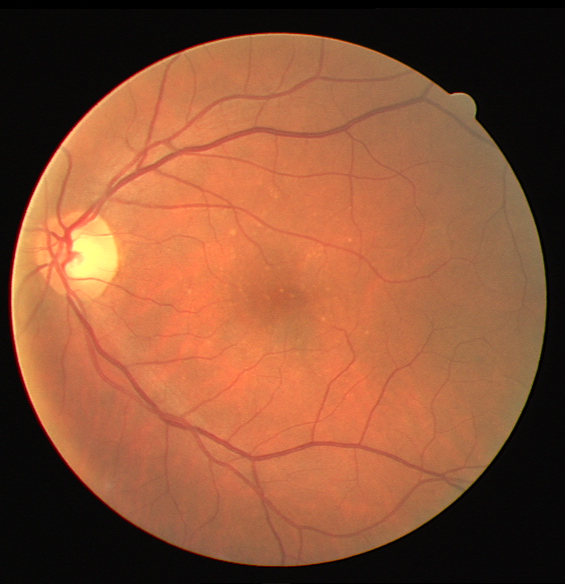

In [11]:
PIL.Image.fromarray(np.uint8(train_images['21'])).convert('RGB')

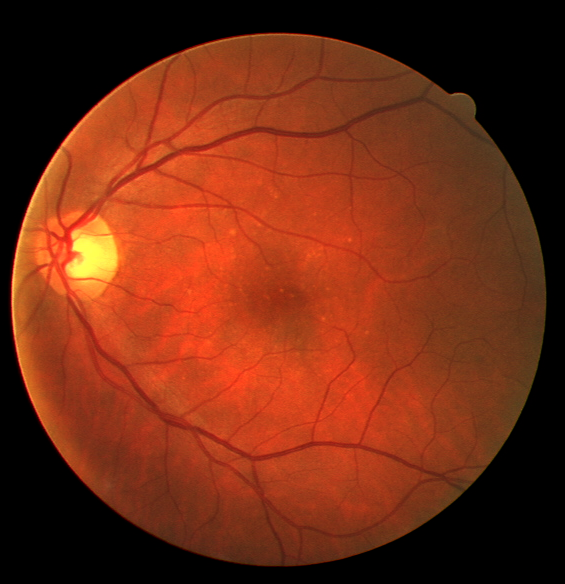

In [23]:
TF.adjust_gamma(PIL.Image.fromarray(np.uint8(train_images['21'])).convert('RGB'), np.random.uniform(1.8, 1.8))

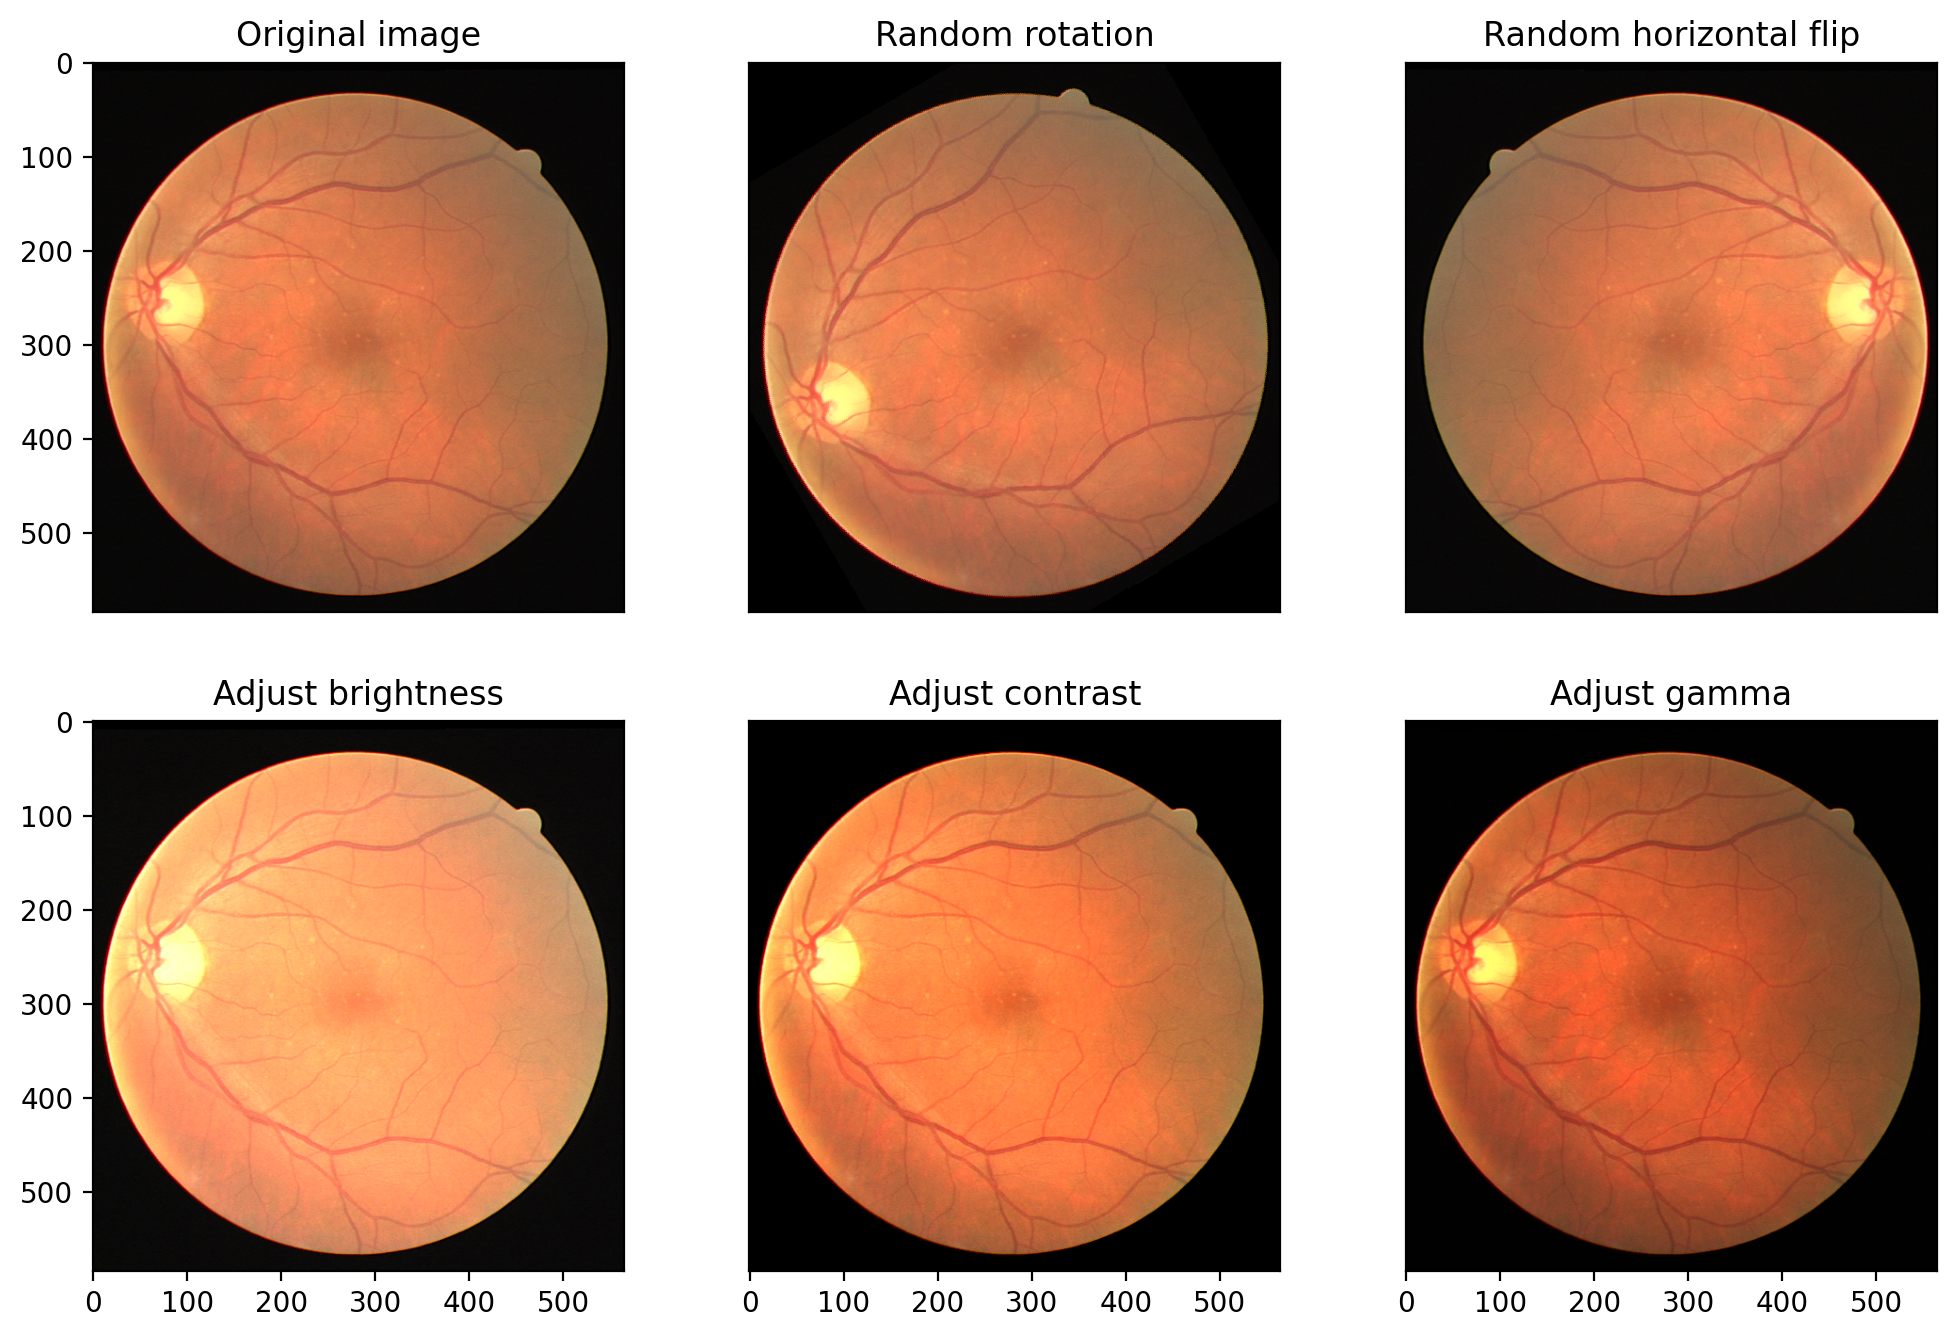

In [62]:
plt.rcParams["figure.figsize"] = [12, 8]
plt.rcParams["figure.dpi"] = 200

giro = TF.rotate(PIL.Image.fromarray(np.uint8(train_images['21'])).convert('RGB'), 30)
flip = TF.hflip(PIL.Image.fromarray(np.uint8(train_images['21'])).convert('RGB'))
brillo = TF.adjust_brightness(PIL.Image.fromarray(np.uint8(train_images['21'])).convert('RGB'), np.random.uniform(1.4, 1.4))
contraste = TF.adjust_contrast(PIL.Image.fromarray(np.uint8(train_images['21'])).convert('RGB'), np.random.uniform(1.4, 1.4))
gamma = TF.adjust_gamma(PIL.Image.fromarray(np.uint8(train_images['21'])).convert('RGB'), np.random.uniform(1.4, 1.4))

fig, axs = plt.subplots(2, 3)
axs[0,0].imshow(train_images['21'])
axs[0,1].imshow(giro)
axs[0,2].imshow(flip)
axs[1,0].imshow(brillo)
axs[1,1].imshow(contraste)
axs[1,2].imshow(gamma)
for i in range(1,3):
    axs[0,i].set_ylim(axs[0,0].get_ylim() ) # align axes
    axs[0,i].set_yticks([]) # set ticks to be empty (no ticks, no tick-labels)
for i in range(1,3):
    axs[1,i].set_ylim(axs[1,0].get_ylim() ) # align axes
    axs[1,i].set_yticks([]) # set ticks to be empty (no ticks, no tick-labels)

axs[0, 0].set_title('Original image')
axs[0, 1].set_title('Random rotation')
axs[0, 2].set_title('Random horizontal flip')
axs[1, 0].set_title('Adjust brightness')
axs[1, 1].set_title('Adjust contrast')
axs[1, 2].set_title('Adjust gamma')

for i in range(0,3):
    axs[0,i].set_xlim(axs[1,0].get_xlim() ) # align axes
    axs[0,i].set_xticks([]) # set ticks to be empty (no ticks, no tick-labels)

Text(0.5, 1.0, 'Random noise')

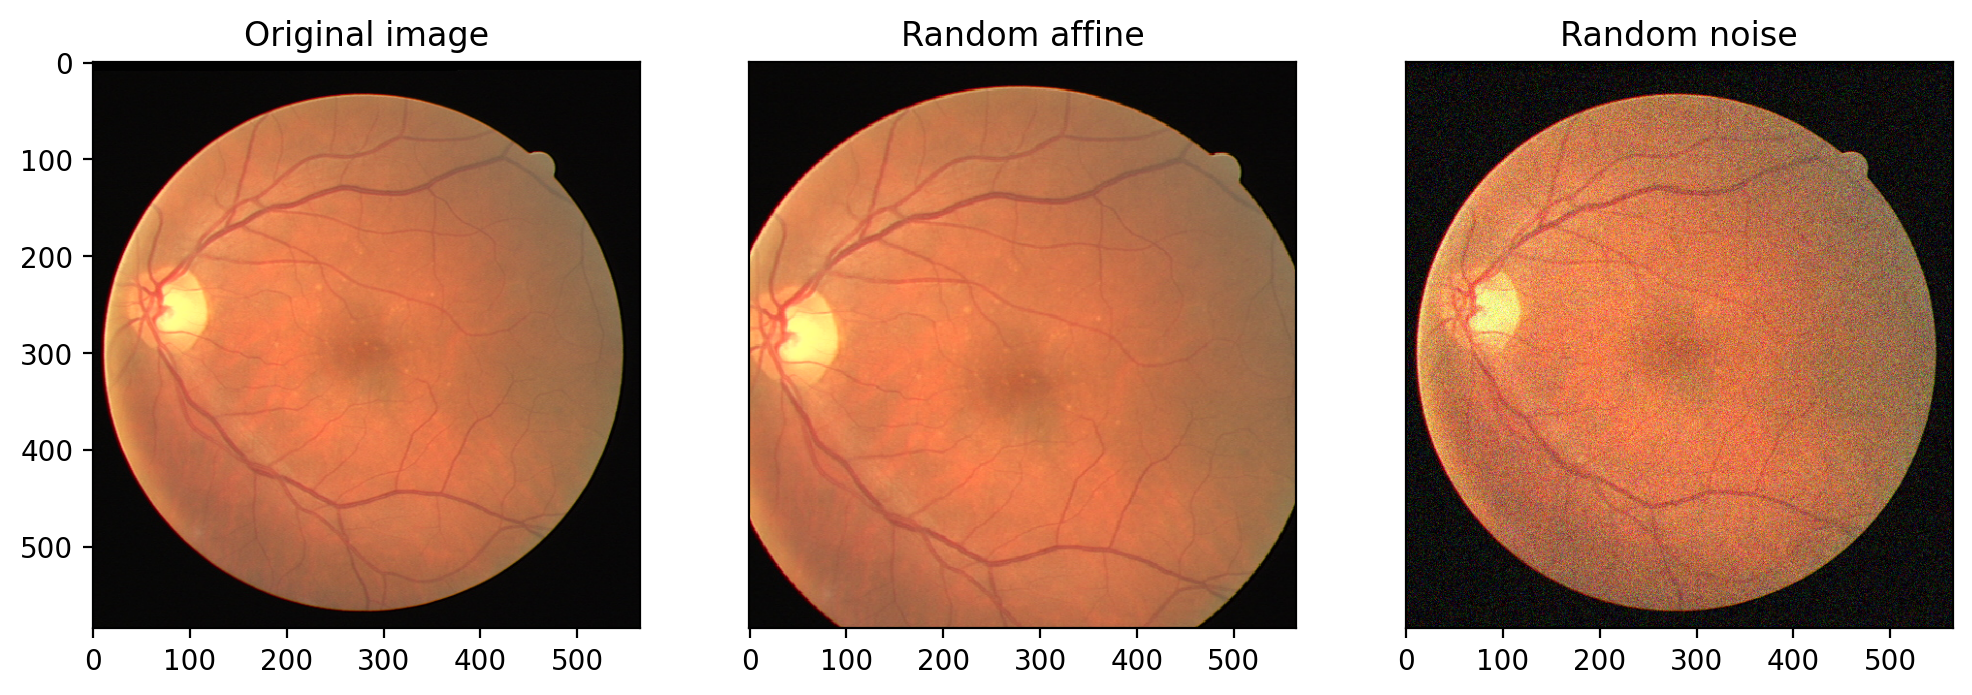

In [33]:
plt.rcParams["figure.figsize"] = [12, 8]
plt.rcParams["figure.dpi"] = 200

transform=Compose([
    ToTensor(),
    AddGaussianNoise(0, 0.1)
])

affine_param = RandomAffine.get_params(
                degrees=[0, 0], translate=[0, 0.1],
                img_size=[584, 565], scale_ranges=[1, 1.2],
                shears=[0,0])

affine = TF.affine(PIL.Image.fromarray(np.uint8(train_images['21'])).convert('RGB'),
affine_param[0], affine_param[1], affine_param[2], affine_param[3])

noisy = transform(train_images['21'])


fig, axs = plt.subplots(1, 3)
axs[0].imshow(train_images['21'])
axs[2].imshow(noisy.permute(1,2,0))
axs[1].imshow(affine)

for i in range(1,3):
    axs[i].set_ylim(axs[0].get_ylim() ) # align axes
    axs[i].set_yticks([]) # set ticks to be empty (no ticks, no tick-labels)

axs[0].set_title('Original image')
axs[1].set_title('Random affine')
axs[2].set_title('Random noise')


In [12]:
#Procesado de los labels

In [13]:
path_labels = "../Data/dataset_DRIVE/training/1st_manual/"
training_labels = os.listdir(path_labels)
labels = {}
for image in training_labels:
    img = np.array(PIL.Image.open(f'{path_labels}{image}').convert("L"), dtype=np.float32)
    labels[image[0:2]] = img

Text(0.5, 1.0, '21')

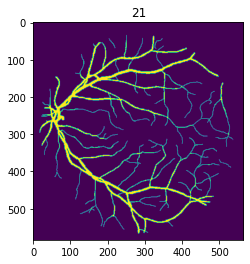

In [14]:
plt.imshow(labels['21'])
plt.title('21')

In [15]:
zeros = []
ones = []
for i in labels.keys():
    aux = labels[i]
    zeros.append(np.sum(aux==0).sum())
    ones.append(np.sum(aux==255).sum())

print(f"Avg_ratio: {np.mean(zeros)/np.mean(ones)}")

Avg_ratio: 10.646914517168044


Text(0.5, 1.0, '21')

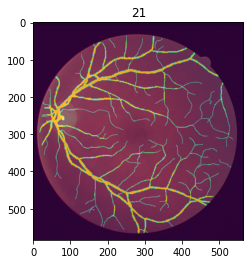

In [16]:
plt.imshow(labels['21'], alpha=1)
plt.imshow(train_images['21'], alpha=0.4)
plt.title('21')

In [11]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# Training Loader params

kwargs = {'train_dir': '../Data/dataset_DRIVE/training/images',
          'train_maskdir': '../Data/dataset_DRIVE/training/1st_manual',
          'val_dir': '../Data/dataset_DRIVE/validation/images',
          'val_maskdir': '../Data/dataset_DRIVE/validation/1st_manual',
          'batch_size': 3,
          'rotation': [-45, 45],
          'hflip_prob': 0.3,
          'brightness': [0.5, 1.5],
          'contrast': [0.5, 1.5],
          'gamma': [0.7, 1.3],
          'affine_prob': 0.4,
          'affine_translate': [0.05, 0.1],  # Horiz and vert translation
          'affine_scale': [1, 1.3],
          'affine_shears': [0, 0],
          'noise': (0, 0.2),  # (Mean,std)
          'num_workers': 0,
          'pin_memory': True}

In [28]:
train_loader, val_loader = get_loaders(**kwargs)

Feature batch shape: torch.Size([3, 3, 584, 565])
Labels batch shape: torch.Size([3, 584, 565])
The Train image numbers present in the batch are: ('40', '29', '39')


Text(0.5, 1.0, '40')

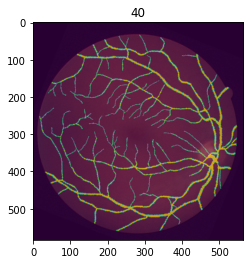

In [35]:
train_features, train_labels, numbers = next(iter(train_loader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
print(f"The Train image numbers present in the batch are: {numbers}")
img = train_features[0].squeeze()
label = train_labels[0]
number = numbers[0]
plt.imshow(label, alpha=1)
plt.imshow(img.permute(1, 2, 0) , alpha=0.4)
plt.title(number)

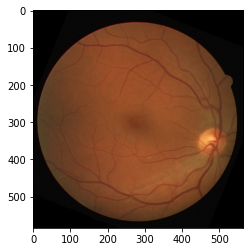

In [36]:
plt.imshow(img.permute(1, 2, 0) , alpha=1)

# Model 

In [15]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

checks1 = "./Checkpoints/2022_01_30_1/training_logs.pt"
checks2 = "./Checkpoints/2022_02_13_2/training_logs.pt"
checks3 = "./Checkpoints/2022_02_12_5/training_logs.pt"


weights1 = "./Checkpoints/2022_01_30_1/my_check.pth.tar"
weights2 = "./Checkpoints/2022_02_13_2/my_check.pth.tar"
weights3 = "./Checkpoints/2022_02_12_5/my_check.pth.tar"


params1 = "./Checkpoints/2022_01_30_1/training_params.pt"
params2 = "./Checkpoints/2022_02_13_2/training_params.pt"
params3 = "./Checkpoints/2022_02_12_5/training_params.pt"


In [7]:
parametros1 = torch.load(params1)
parametros2 = torch.load(params2)
parametros3 = torch.load(params3)

In [8]:
print(f'Parámetros mejores: {parametros2["DICE"]} VS alternativa {parametros3["DICE"]}')

Parámetros mejores: 0.8203941479581462 VS alternativa 0.8116505942212329


In [9]:
parametros3

{'LR': 0.002,
 'BATCH_SIZE': 2,
 'NUM_EPOCHS': 1000,
 'LOSS_WEIGHTS': 1,
 'ROTATION': [-180, 180],
 'HFLIP_PROB': 0.4,
 'BRIGHTNESS': [0.8, 1.2],
 'CONTRAST': [0.8, 1.2],
 'GAMMA': [0.9, 1.1],
 'AFFINE_PROB': 0.3,
 'AFFINE_TRANSLATE': [0.0, 0.1],
 'AFFINE_SCALE': [1, 1.2],
 'AFFINE_SHEARS': [0, 0],
 'NOISE': (0, 0.1),
 'DICE': 0.8116505942212329,
 'ACCURACY': 0.9686893865923143,
 'AUC': 0.9869289389256963}

In [112]:
a = torch.load(checks1)
b = torch.load(checks2)
c = torch.load(checks3)

In [113]:
print(a["best_auc"])
print(a["best_accuracy"])
print(a["best_dice"])

0.9840781571429302
0.9639016850527338
0.8002492205641609


In [114]:
print(b["best_auc"])
print(b["best_accuracy"])
print(b["best_dice"])

0.9871122198271974
0.9667111164989696
0.8203941479581462


In [115]:
print(c["best_auc"])
print(c["best_accuracy"])
print(c["best_dice"])

0.9869289389256963
0.9686893865923143
0.8116505942212329


In [150]:
i=0
mean_loss_epoch= []
mean_loss_hundred = []
while i<16000:
    mean_loss_epoch.append(np.mean(a['loss'][i:i+15]))
    i+=16
i=0

while i<16000:
    mean_loss_hundred.append(np.mean(a['loss'][i:i+1600]))
    i+=1600

Text(0, 0.5, 'Loss')

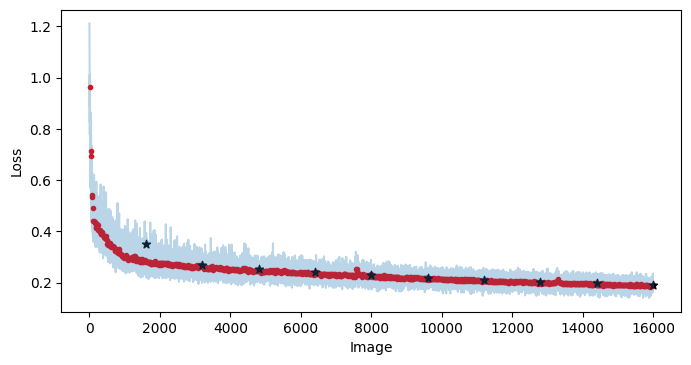

In [151]:
plt.rcParams["figure.figsize"] = [8,4]
plt.rcParams["figure.dpi"] = 100

plt.plot(range(len(a['loss'])), a['loss'], alpha=0.3)
plt.scatter(range(16, 16016, 16), mean_loss_epoch, c="r", marker=".")
plt.scatter(range(1600, 17600, 1600), mean_loss_hundred, c="k", marker="*")
plt.xlabel("Image")
plt.ylabel("Loss")

In [181]:
checkpoints_x = []
checkpoints_y = []
k = 0
for i,j in zip(a['val_dice'], a['saved']):
    if j:
        checkpoints_x.append(k)
        checkpoints_y.append(i)
    k+=1

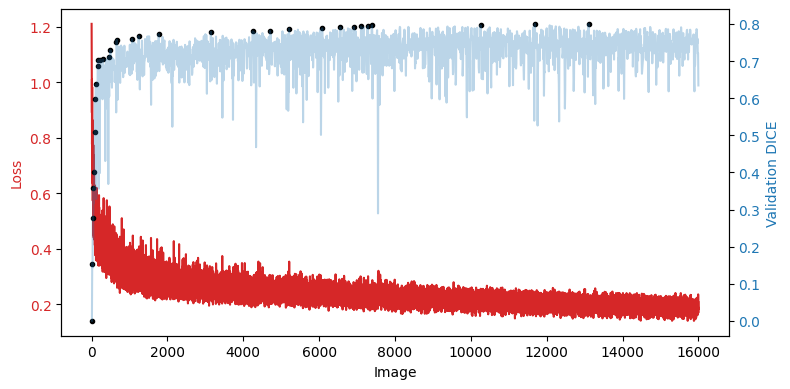

In [195]:
#Saco la media de las 4 imágenes (2 batches) para sacar el dice medio por epoch
i=0
val_dice = []
while i<2000:
    val_dice.append(np.mean(a['val_dice'][i:i+1]))
    i+=2

fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Image')
ax1.set_ylabel('Loss', color=color)
ax1.plot(range(len(a['loss'])), a['loss'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Validation DICE', color=color)  # we already handled the x-label with ax1
ax2.plot(range(8, 16008, 8), a['val_dice'], color=color, alpha=0.3)
ax2.scatter([(i+1)*8 for i in checkpoints_x], checkpoints_y, color='k', marker=".")


ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

Text(0, 0.5, 'Loss')

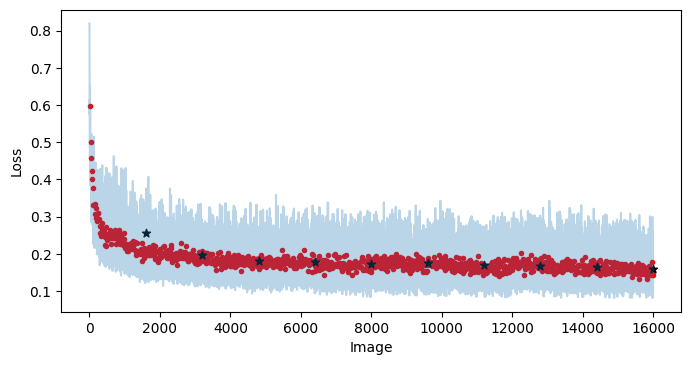

In [131]:
#Best model
i=0
mean_loss_epoch= []
mean_loss_hundred = []
while i<16000:
    mean_loss_epoch.append(np.mean(b['loss'][i:i+16]))
    i+=16
i=0

while i<16000:
    mean_loss_hundred.append(np.mean(b['loss'][i:i+1600]))
    i+=1600

plt.rcParams["figure.figsize"] = [8,4]
plt.rcParams["figure.dpi"] = 100

plt.plot(range(len(b['loss'])), b['loss'], alpha=0.3)
plt.scatter(range(16, 16016, 16), mean_loss_epoch, c="r", marker=".")
plt.scatter(range(1600, 17600, 1600), mean_loss_hundred, c="k", marker="*")
plt.xlabel("Image")
plt.ylabel("Loss")

# Submission Grand Challenge

In [5]:
TEST_IMG_DIR = "../Data/dataset_DRIVE/test"

In [6]:
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchvision import transforms
from utils import make_grid

In [7]:
test = ImageFolder(root=TEST_IMG_DIR, transform=transforms.ToTensor())

In [8]:
BATCH_SIZE = 4
test_loader = DataLoader(test, batch_size=BATCH_SIZE)

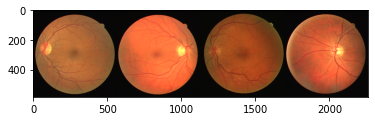

In [17]:
#First 4 test images
grid = make_grid(next(iter(test_loader))[0], nrow=4, padding=0, scale_each=True)
plt.imshow(grid.numpy().transpose((1, 2, 0)))

In [5]:
model = UNET(in_channels=3, out_channels=1).to(DEVICE)

In [7]:
def get_n_params(model):
    pp=0
    for p in list(model.parameters()):
        nn=1
        for s in list(p.size()):
            nn = nn*s
        pp += nn
    return pp

In [8]:
get_n_params(model)

31037633

In [118]:
# Predictions
folder = "../Data/dataset_DRIVE/submit/2022_02_12_5"
model = UNET(in_channels=3, out_channels=1).to(DEVICE)
load_checkpoint(torch.load(weights3, map_location=torch.device(DEVICE)),
    model)
model.eval()
number = list(range(1,5,1))
for x in test_loader:
    x = x[0].to(device=DEVICE)
    with torch.no_grad():
        preds = torch.sigmoid(model(x))
        preds = (preds > 0.5).float()
        for a,b in zip(preds,number):
            torchvision.utils.save_image(
            a, f"{folder}/{b}.png")
    number = [x + BATCH_SIZE for x in number]


 => Loading checkpoint 


In [16]:
folder = "../Data/dataset_DRIVE/submit/2022_02_12_5"
model = UNET(in_channels=3, out_channels=1).to(DEVICE)
load_checkpoint(torch.load(weights3, map_location=torch.device(DEVICE)),
    model)
model.eval()

 => Loading checkpoint 


UNET(
  (ups): ModuleList(
    (0): ConvTranspose2d(1024, 512, kernel_size=(2, 2), stride=(2, 2))
    (1): DoubleConv(
      (conv): Sequential(
        (0): Conv2d(1024, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace=True)
      )
    )
    (2): ConvTranspose2d(512, 256, kernel_size=(2, 2), stride=(2, 2))
    (3): DoubleConv(
      (conv): Sequential(
        (0): Conv2d(512, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), p

In [18]:
problematic = next(iter(test_loader))[0][0]

In [19]:
problematic = problematic.unsqueeze(0)
x = problematic.to(device=DEVICE)
with torch.no_grad():
    preds = torch.sigmoid(model(x))
    preds = (preds > 0.5).float()

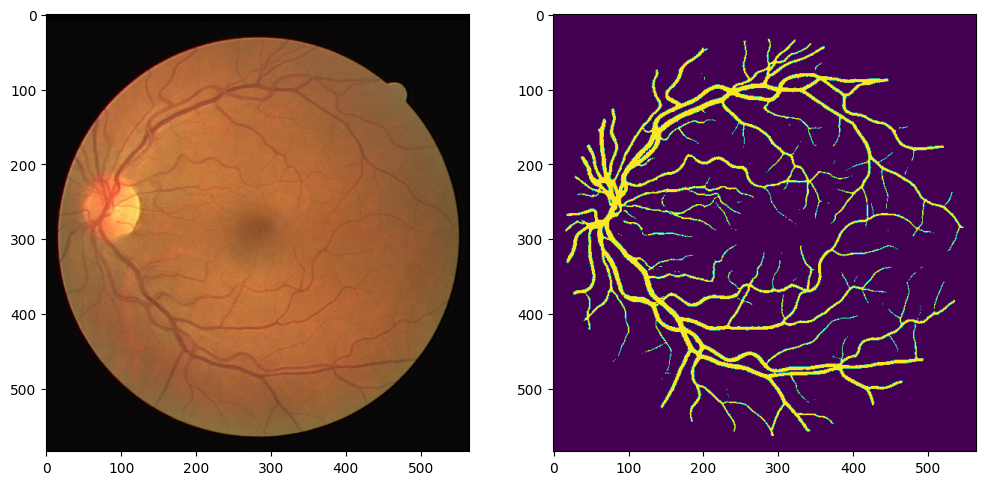

In [21]:
plt.rcParams["figure.figsize"] = [12, 8]
plt.rcParams["figure.dpi"] = 100

fig, ax = plt.subplots(1,2)
ax[0].imshow(problematic.squeeze(0).permute(1, 2, 0))
ax[1].imshow(preds.squeeze(0).squeeze(0))